In [1]:
import os
import numpy as np

In [2]:
videos = np.load('/kaggle/input/npy-dikit/videosCorrectDikit.npy')
labels = np.load('/kaggle/input/npy-dikit/labelsCorrectDikit.npy')
videos = videos / 255

# Developing Model

In [3]:
!pip install protobuf==3.20.*

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import models, Input
import gc
from tensorflow.keras import regularizers

2026-01-07 15:47:58.981691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767800879.183134     397 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767800879.232835     397 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767800879.650452     397 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767800879.650497     397 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767800879.650500     397 computation_placer.cc:177] computation placer alr

In [5]:
encoder = LabelEncoder()
encoder.fit(labels)
print(encoder.classes_)
print(len(encoder.classes_))
encoded_labels = encoder.transform(labels)
labels = encoded_labels

['air' 'bakso' 'doa' 'kopi' 'novel' 'puding' 'rumus' 'surat']
8


In [6]:
label_dict = {0: 'air', 1: 'bakso', 2: 'doa', 3: 'kopi', 4: 'novel', 5: 'puding', 6: 'rumus', 7: 'surat'}

In [7]:
x_train, x_test, y_train, y_test = train_test_split(videos, labels, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

del videos

In [8]:
gc.collect()
!cat /proc/meminfo | grep Mem

MemTotal:       32873508 kB
MemFree:        15644796 kB
MemAvailable:   19428896 kB


air       164 counts
bakso     152 counts
doa       153 counts
kopi      159 counts
novel     152 counts
puding    152 counts
rumus     157 counts
surat     160 counts


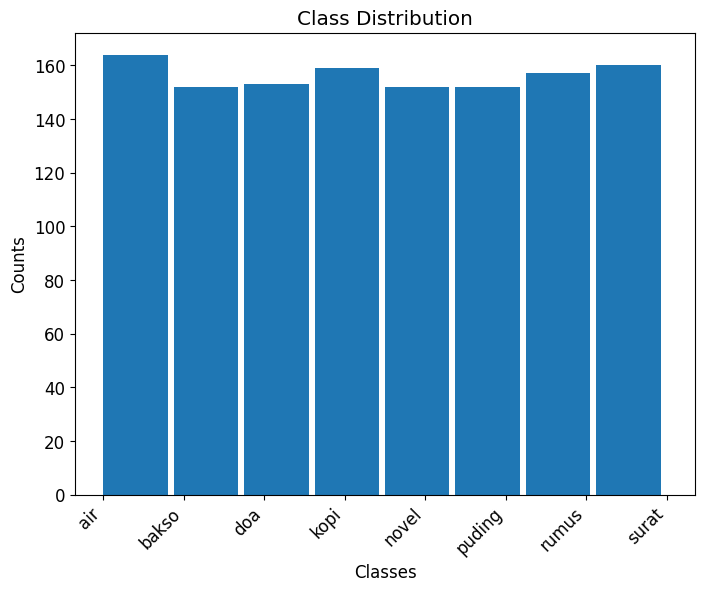

In [9]:
import matplotlib.pyplot as plt

classes = np.unique(labels) 
counts = np.bincount(labels, minlength=len(classes)) 
max_len = max([len(label_dict[i]) for i in range(len(label_dict))]) 
for i, count in enumerate(counts): 
    class_name = label_dict[i].ljust(max_len)
    print("{}    {} counts".format(class_name, count))

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 12})
plt.hist(labels, bins = len(classes), width=0.8)
plt.xticks(range(len(classes)), [label_dict[i] for i in range(len(classes))], rotation = 45, ha = 'right')
plt.xlabel("Classes")
plt.ylabel("Counts")
plt.title("Class Distribution")
plt.show()

In [10]:
from tensorflow.keras.regularizers import l2

inputs = Input((45, 80, 112, 3))

x = tf.keras.layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(inputs)
x = tf.keras.layers.MaxPooling3D((1, 2, 2))(x)
x = tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling3D((1, 2, 2))(x)
x = tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling3D((1, 2, 2))(x)

x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False))(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(8, activation='softmax')(x)

I0000 00:00:1767800893.724096     397 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [11]:
model = models.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_val = tf.keras.utils.to_categorical(y_val)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 45, 80, 112, 3) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 45, 80, 112,    │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 45, 40, 56, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 45, 40, 56, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 45, 20, 28, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 45, 20, 28, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 45, 10, 14, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 45, 8960)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 45, 128)        │     4,620,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 45, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,791,176 (18.28 MB)

 Trainable params: 4,791,176 (18.28 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
x_train.shape

(874, 45, 80, 112, 3)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    x_train,
    y_train,
    batch_size = 16,
    validation_data = (x_val, y_val),
    epochs = 100,
    callbacks = EarlyStopping(monitor = 'val_accuracy', patience  = 5, restore_best_weights = True)
)

Epoch 1/100


I0000 00:00:1767800913.911785     460 cuda_dnn.cc:529] Loaded cuDNN version 91002


55/55 ━━━━━━━━━━━━━━━━━━━━ 28s 298ms/step - accuracy: 0.1380 - loss: 2.1122 - val_accuracy: 0.1702 - val_loss: 2.0358
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.2183 - loss: 1.9988 - val_accuracy: 0.3564 - val_loss: 1.6586
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.5165 - loss: 1.3214 - val_accuracy: 0.7713 - val_loss: 0.7660
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.7726 - loss: 0.6921 - val_accuracy: 0.7766 - val_loss: 0.6160
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.8202 - loss: 0.5341 - val_accuracy: 0.8830 - val_loss: 0.3655
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.8979 - loss: 0.3002 - val_accuracy: 0.8564 - val_loss: 0.4145
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.9268 - loss: 0.2331 - val_accuracy: 0.9043 - val_loss: 0.3095
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.9647 - loss: 0.1214 - val_accuracy

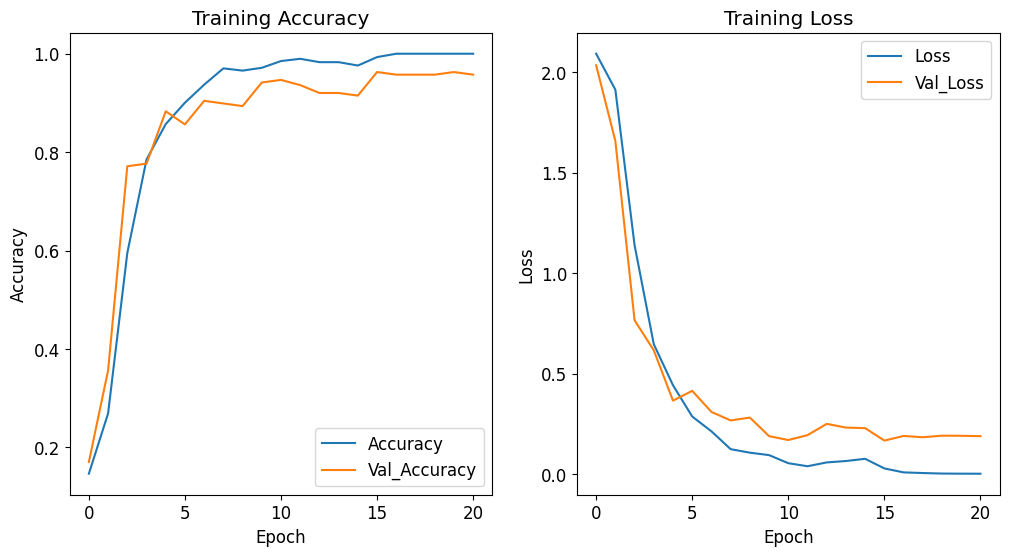

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Test Evaluation

In [15]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Acc: ", test_acc)
print("Test Loss: ", test_loss)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - accuracy: 0.9903 - loss: 0.0483
Test Acc:  0.9893048405647278
Test Loss:  0.06254279613494873


In [16]:
from sklearn.metrics import classification_report, confusion_matrix

y_test_labels = np.argmax(y_test, axis=1)
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
report = classification_report(y_test_labels, y_pred)
print(report)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        24
           2       1.00      0.96      0.98        25
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        20
           5       1.00      0.95      0.98        21
           6       1.00      1.00      1.00        29
           7       0.91      1.00      0.95        21

    accuracy                           0.99       187
   macro avg       0.99      0.99      0.99       187
weighted avg       0.99      0.99      0.99       187



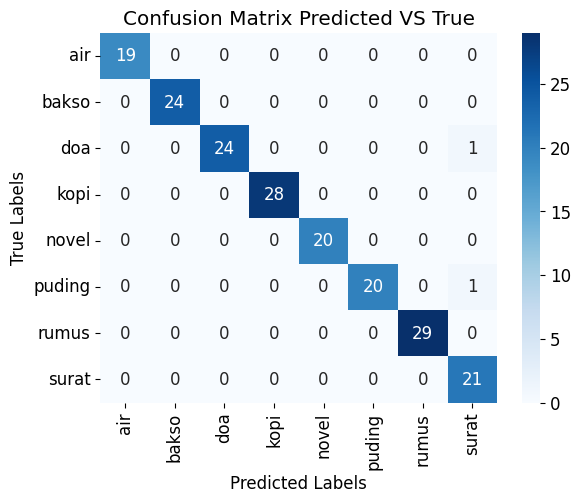

In [17]:
import seaborn as sns

conf_matrix = confusion_matrix(y_test_labels, y_pred)
label_strings = [label_dict[i] for i in range(len(label_dict))]
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=label_strings, yticklabels=label_strings)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Predicted VS True")
plt.show()

In [18]:
# model.save("model_3DCNN+LSTM.keras")